# Solving the SWE using NN + FNO

In [48]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN, BatchNormalization, Dropout

#from tensorflow.keras.optimizers import Adam
#import tensorflow as tf

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim


## Load data

In [2]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape
sigma = mat_data['sigma'][0,0]

print('sigma:', sigma)


dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])
sigma: 0.1


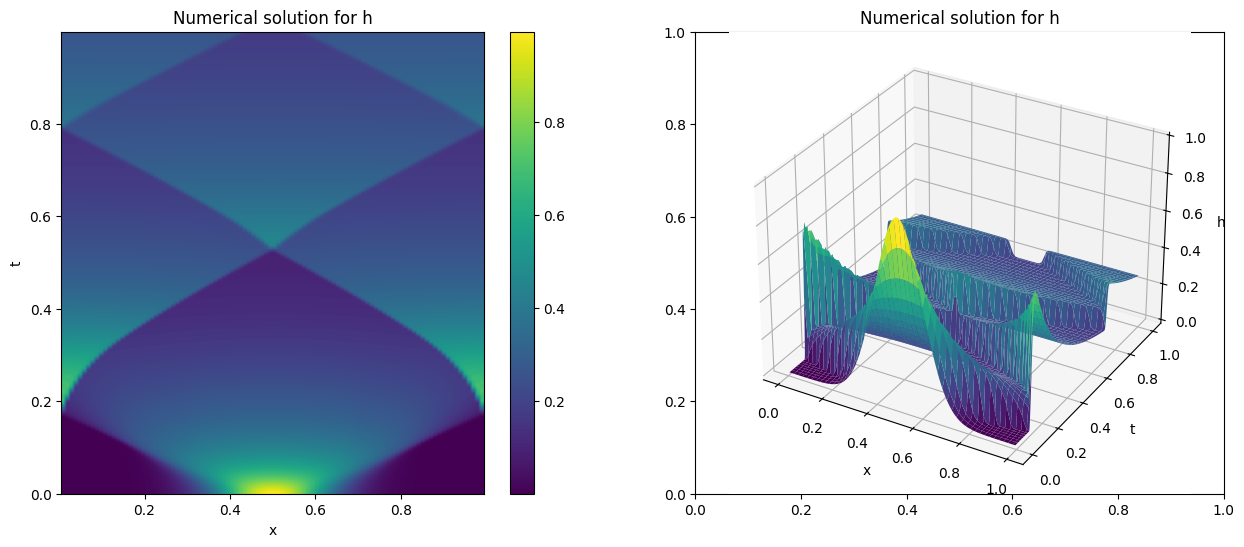

In [3]:
save = 0

# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


In [61]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Define the input and output data for the training sets
X_train = h_train[:-1, :]
Y_train = h_train[1:, :]

X_test = h_test[:-1, :]
Y_test = h_test[1:, :]

## Solve the SWE using NN

### (i) FNN

In [62]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [116]:
in_features = 100
hidden1 = 128
hidden2 = 128
hidden3 = 64
out_features = 100

model = nn.Sequential(
    nn.Linear(in_features, hidden1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden2, hidden3),
    nn.Linear(hidden3, out_features),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=100, bias=True)
  (8): Sigmoid()
)


In [ ]:
X = h_train

# Assuming X has shape (243, 100) (time steps, spatial steps)
input_data = X[:-1]  # Shape: (242, 100)
output_data = X[1:]  # Shape: (242, 100)

# Create a DataLoader for batches
dataset = torch.utils.data.TensorDataset(torch.tensor(input_data, dtype=torch.float32),
                                         torch.tensor(output_data, dtype=torch.float32))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [166]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 500

for epoch in range(n_epochs):
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")
    losses.append(loss.item())    

Epoch 1/500, Loss: 0.000659024459309876
Epoch 2/500, Loss: 0.0005915630026720464
Epoch 3/500, Loss: 0.0006953372503630817
Epoch 4/500, Loss: 0.0006524710333906114
Epoch 5/500, Loss: 0.0005951554048806429
Epoch 6/500, Loss: 0.0007968462305143476
Epoch 7/500, Loss: 0.0007160872337408364
Epoch 8/500, Loss: 0.0006067009526304901
Epoch 9/500, Loss: 0.0008325879462063313
Epoch 10/500, Loss: 0.0006677599740214646
Epoch 11/500, Loss: 0.0008056404767557979
Epoch 12/500, Loss: 0.0007233429350890219
Epoch 13/500, Loss: 0.0007588330190628767
Epoch 14/500, Loss: 0.0006749770254828036
Epoch 15/500, Loss: 0.0005947662866674364
Epoch 16/500, Loss: 0.0006150705157779157
Epoch 17/500, Loss: 0.0006344395806081593
Epoch 18/500, Loss: 0.0006941863102838397
Epoch 19/500, Loss: 0.000756173743866384
Epoch 20/500, Loss: 0.000640665297396481
Epoch 21/500, Loss: 0.0006971577531658113
Epoch 22/500, Loss: 0.0007481897482648492
Epoch 23/500, Loss: 0.0008752487483434379
Epoch 24/500, Loss: 0.0007913365843705833
Epoc

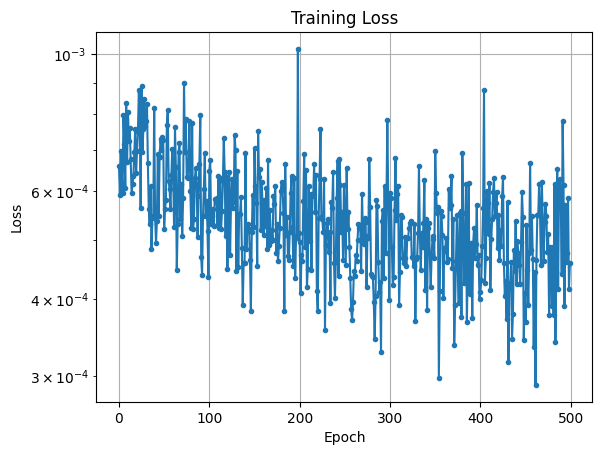

In [167]:
# Plot loss
plt.semilogy(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()


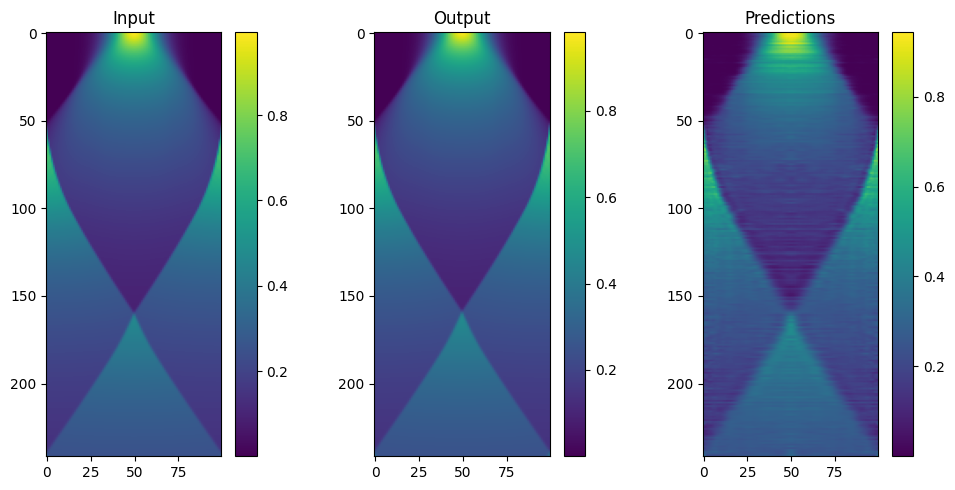

In [168]:
# make probability predictions with the model
predictions = model(X_train)

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_train)
plt.colorbar()
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(Y_train)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 3)
plt.imshow(predictions.detach().numpy())
plt.colorbar()
plt.title('Predictions')

plt.tight_layout()

plt.show()


### (ii) RNN Flowmap

In [169]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [173]:
X = h_train

input_data = X[:-1]  
output_data = X[1:] 

# Create a DataLoader for batches
dataset = torch.utils.data.TensorDataset(torch.tensor(input_data, dtype=torch.float32),
                                         torch.tensor(output_data, dtype=torch.float32))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out

# Instantiate the model
model = RNNFlowmap(input_size=100, hidden_size=50, output_size=100)

# Input shape for RNN: (batch_size, sequence_length, input_size)

print(model)

RNNFlowmap(
  (rnn): RNN(100, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=100, bias=True)
)


In [177]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 50

for epoch in range(n_epochs):
    for batch_X, batch_y in data_loader:
        # Forward pass
        print(batch_X.shape)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")
    losses.append(loss.item())


torch.Size([32, 100])


IndexError: too many indices for tensor of dimension 2